In [95]:
import os
from collections import defaultdict
import re, string, unicodedata
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import pickle
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [96]:
data = pd.read_csv(os.path.join(os.getcwd(), 'data', 'train_data.csv')) 
test_data = pd.read_csv(os.path.join(os.getcwd(), 'data', 'test_data.csv')) 

data_copy = data.copy()

In [97]:
import enchant
eng_dict = enchant.Dict("en_US")

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            try:
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            except Exception as e:
                print(str(e))
                pass
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def remove_no_english(words):
    new_words = []
    for word in words:
        if eng_dict.check(word):
            new_words.append(word)
    return new_words

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v') #zakładay, ze wszytsie slowa sa czasownikami
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words  = remove_no_english(words)
    return words

In [98]:
def remove_urls(text):
    txt = re.sub(r'pic\.twitter\.com.*?( |$)', '', text)
    txt = re.sub(r'http.+?\xa0', '', txt)
    return re.sub(r'http.+?( |$)', '', txt)

def remove_marks(text):
    return re.sub(r'@ ?.*?( |$)', '', text)

In [99]:
for tweet_id, tweet in enumerate(data['content']):
    t = (remove_urls(tweet).casefold())
    t = remove_marks(t)
    t = nltk.word_tokenize(t)
    t = normalize(t)
    data['content'][tweet_id] = t

In [100]:
data

,sentiment,content
0,empty,"[know, bad, habit, earlier, started, part]"
1,sadness,"[n, bed, headache, call]"
2,sadness,"[funeral, ceremony, gloomy]"
3,enthusiasm,"[wants, hang, friends, soon]"
4,neutral,"[want, trade, someone, tickets, one]"
5,worry,"[go, prom, bf, like, friends]"
6,sadness,"[sleep, thinking, old, friend, want, married, ..."
7,worry,[]
8,sadness,"[love, miss]"
9,sadness,"[sorry, least]"


Usunięte elementy

In [101]:
data_copy[data['content'].map(len) == 0]

,sentiment,content
7,worry,Hmmm. http://www.djhero.com/ is down
98,neutral,PrinceCharming
124,hate,@britblackbird youstinkatrespondingtotexts!
156,neutral,"where are all ma bestfriends at ? , MIA or wat ?"
220,neutral,@MrRathbone what about me
293,happiness,@vinylvickxen i kno i doooo!!!!!!!!!! yall par...
305,neutral,@sillybabyjulie me too
358,neutral,in 7-11 w/o you
464,neutral,"@taylor_d No, it's not..."
494,anger,fuckin'm transtelecom


In [102]:
print(f"removing {len(data[data['content'].map(len) == 0])} empty rows from data")
data = data[data['content'].map(len) > 0]

removing 529 empty rows from data


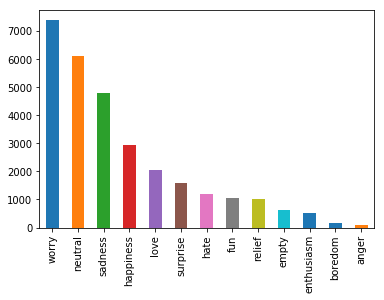

In [103]:
sentiment_freq = data['sentiment'].value_counts()
fig, ax = plt.subplots()

sentiment_freq.plot(ax=ax, kind='bar')

In [ ]:
for tweet_id, tweet in enumerate(test_data['content']):
    t = (remove_urls(tweet).casefold())
    t = remove_marks(t)
    t = nltk.word_tokenize(t)
    t = normalize(t)
    
    test_data['content'][tweet_id] = t

In [105]:
words_vocabulary = set([item for sublist in data['content'] for item in sublist])
words_vocabulary

{'dumpster',
 'weekdays',
 'countries',
 'unsociable',
 'buyer',
 'lecturer',
 'yesterday',
 'carnival',
 'snatched',
 'diagnosis',
 'hurricane',
 'ulcers',
 'spin',
 '80th',
 'shin',
 'helped',
 'amen',
 'showroom',
 'greatly',
 'toke',
 'blisters',
 'strangers',
 'kudos',
 'highway',
 'ya',
 'hurt',
 'contemporary',
 'personal',
 'gallery',
 'profound',
 'shines',
 'weirdly',
 'came',
 'sun',
 'ruining',
 'charity',
 'moped',
 'planner',
 'kernel',
 'lobbyists',
 'inland',
 'studios',
 'cancel',
 'trance',
 'figuring',
 'ford',
 'sans',
 'captain',
 'trackballs',
 'produces',
 'leaks',
 'school',
 'windows',
 'decoration',
 'burners',
 'vets',
 'took',
 'live',
 'corrupt',
 'uniforms',
 'mpg',
 'hardcore',
 'minivan',
 'resigned',
 'rearranging',
 'losing',
 'insanity',
 'forgiving',
 'altered',
 'witty',
 'rescuing',
 'conviction',
 'sound',
 'produced',
 'perused',
 'worked',
 'attacking',
 'homesick',
 'abuzz',
 'goodbye',
 'gin',
 'heartburn',
 'nightmare',
 'supporting',
 'raffl